## Import Libraries

In [46]:
# Imports here
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models import vgg16
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim, cuda
import time
import copy
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Load Dataset

In [54]:
data_dir = '/kaggle/input/flower-data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

## Transform Data

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir,transform = data_transforms['train']),
    'val': datasets.ImageFolder(valid_dir,transform = data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform = data_transforms['test'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train':DataLoader(image_datasets['train'],batch_size =32,shuffle=True),
              'val':DataLoader(image_datasets['val'],batch_size=32,shuffle=True),
              'test':DataLoader(image_datasets['test'],batch_size=32,shuffle=True)}

In [4]:
n_classes = len(image_datasets['train'].classes)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

## Match Class ID to Name

In [5]:
import json

with open('/kaggle/input/cat-to-name/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
class_to_idx = image_datasets['train'].class_to_idx

In [7]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [8]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Load Pretrained Model

In [9]:
# TODO: Build and train your network
model = vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

## Freeze layers for finetuning

In [11]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [12]:
input_features = model.classifier[0].in_features

## Build Classifier

In [13]:
# Define a custom classifier
model.classifier = nn.Sequential(
    nn.Linear(input_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 102),  # 102 flower classes
    nn.LogSoftmax(dim=1)
)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=102, bias=True)
  (4): LogSoftmax(dim=1)
)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Loss and Optimizer

In [15]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

## Train Model

In [16]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20):
    since = time.time()

    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                print("Training")
            else:
                model.eval()   # Set model to evaluate mode
                print("Evaluating")

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track gradients only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')


    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, dataloaders, criterion, optimizer, device, num_epochs=10
)
   

Epoch 1/10
----------
Training
Train Loss: 2.2081 Acc: 0.4766
Evaluating
Val Loss: 0.8451 Acc: 0.7689

Epoch 2/10
----------
Training
Train Loss: 1.1267 Acc: 0.6966
Evaluating
Val Loss: 0.5303 Acc: 0.8521

Epoch 3/10
----------
Training
Train Loss: 0.9676 Acc: 0.7326
Evaluating
Val Loss: 0.5099 Acc: 0.8545

Epoch 4/10
----------
Training
Train Loss: 0.8581 Acc: 0.7709
Evaluating
Val Loss: 0.4648 Acc: 0.8863

Epoch 5/10
----------
Training
Train Loss: 0.8126 Acc: 0.7775
Evaluating
Val Loss: 0.4891 Acc: 0.8594

Epoch 6/10
----------
Training
Train Loss: 0.7899 Acc: 0.7856
Evaluating
Val Loss: 0.5243 Acc: 0.8753

Epoch 7/10
----------
Training
Train Loss: 0.7747 Acc: 0.7908
Evaluating
Val Loss: 0.4737 Acc: 0.8741

Epoch 8/10
----------
Training
Train Loss: 0.7499 Acc: 0.7937
Evaluating
Val Loss: 0.4693 Acc: 0.8826

Epoch 9/10
----------
Training
Train Loss: 0.7242 Acc: 0.8086
Evaluating
Val Loss: 0.4906 Acc: 0.8875

Epoch 10/10
----------
Training
Train Loss: 0.7094 Acc: 0.8089
Evaluating

## Test Model

In [17]:
def test_model(model, dataloader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')

# Test the model
test_model(model, dataloaders, device)


Test Accuracy: 0.8718


## Save Model

In [18]:
# TODO: Save the checkpoint 
def save_checkpoint(model, class_to_idx, optimizer, epoch, path='checkpoint.pth'):
    checkpoint = {
        'architecture': 'vgg16',
        'classifier': model.classifier,
        'state_dict': model.state_dict(),
        'class_to_idx': class_to_idx,
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, path)
    print(f'Model saved to {path}')

# Save the trained model
save_checkpoint(model, class_to_idx, optimizer, epoch=10)

Model saved to checkpoint.pth


## Load saved Model

In [47]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path='checkpoint.pth'):
    checkpoint = torch.load(path, map_location=device)
    model = vgg16(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.to(device)
    return model

# Example of loading the model
loaded_model = load_checkpoint('checkpoint.pth')

/tmp/ipykernel_36/3990921015.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


## Preporcess Test Image

In [48]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # Load image
    image = Image.open(image_path)

    # Define transforms
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

    image = preprocess(image)
    return image

## Show Predict Image

In [49]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Predict Image

In [50]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    image = process_image(image_path).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = torch.exp(output)
        top_probs, top_classes = probabilities.topk(topk, dim=1)

    # Convert to lists
    top_probs = top_probs.cpu().numpy()[0]
    top_classes = top_classes.cpu().numpy()[0]

    # Invert class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Convert indices to classes
    top_labels = [idx_to_class[class_idx] for class_idx in top_classes]

    return top_probs, top_labels

## Display Prediction

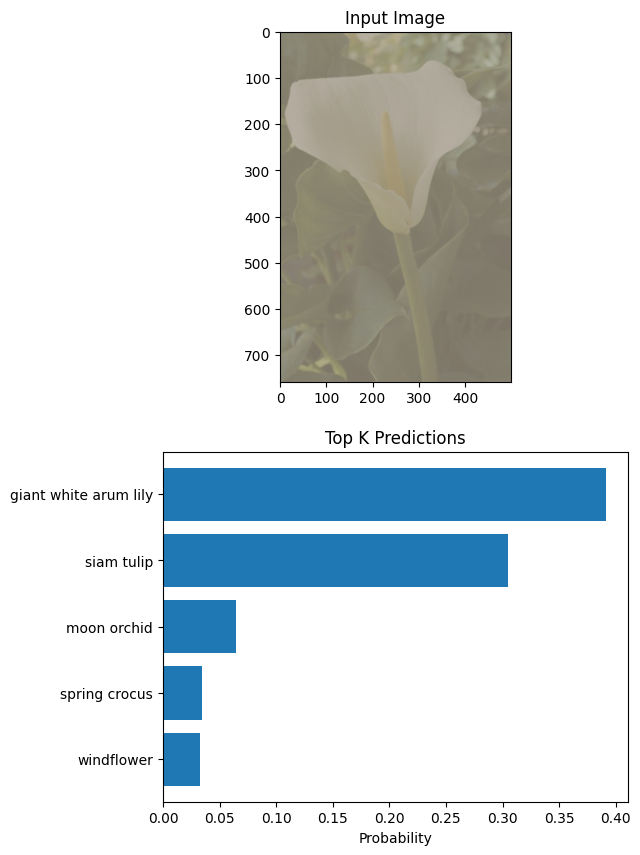

In [52]:
def display_prediction(image_path, model, topk=5):
    probs, classes = predict(image_path, model, topk)
    # Get top class names
    top_class_names = [cat_to_name[str(cls)] for cls in classes]

    # Load and display image
    image = Image.open(image_path)
    plt.figure(figsize=(6,10))
    ax = plt.subplot(2,1,1)
    imshow(transforms.ToTensor()(image), ax=ax)
    plt.title("Input Image")
    
    # Display top K classes
    ax = plt.subplot(2,1,2)
    y_pos = np.arange(topk)
    plt.barh(y_pos, probs[::-1], align='center')
    plt.yticks(y_pos, top_class_names[::-1])
    plt.xlabel('Probability')
    plt.title('Top K Predictions')
    plt.show()



display_prediction(f'/kaggle/input/flower-data/test/20/image_04910.jpg', model,topk=5)